<a href="https://colab.research.google.com/github/saipklvs/LearnDL/blob/main/Torch_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MNIST Data Setup

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)
URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


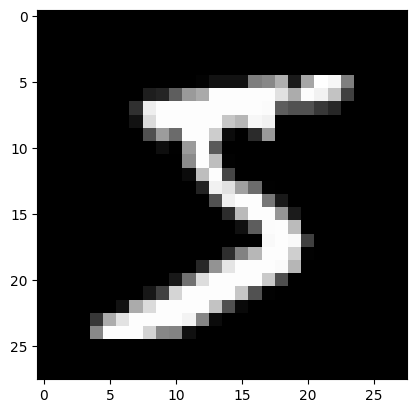

In [3]:
from matplotlib import pyplot as plt
import numpy as np 

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## NN from scratch with out using torch.nn

In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [6]:
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
  return log_softmax(xb @ weights + bias)

In [7]:
bs = 64 ## Batch size

xb    = x_train[0:64]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.6122, -1.9858, -2.1294, -2.4861, -1.8427, -1.9995, -2.8948, -2.6913,
        -2.3383, -2.6060], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [8]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll


In [9]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4412, grad_fn=<NegBackward0>)


In [10]:
def accuracy(out, yb):
  preds = torch.argmax(out, dim=1)
  return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.0781)


## Using torch.nn method now

In [11]:
import torch.nn.functional as F
loss_func = F.cross_entropy
def model(xb):
  return xb @ weights + bias
print(loss_func(model(xb), yb), accuracy(model(xb), yb))


tensor(2.4412, grad_fn=<NllLossBackward0>) tensor(0.0781)


In [12]:
from torch import nn

class Mnist_Logistic(nn.Module):
  def __init__(self) -> None:
      super().__init__()
      self.weights = nn.Parameter(torch.randn(784, 10)/ math.sqrt(784))
      self.bias = nn.Parameter(torch.zeros(10))

  def forward(self, xb):
    return xb @ self.weights + self.bias

model = Mnist_Logistic()

In [13]:
print(loss_func(model(xb), yb))

tensor(2.3385, grad_fn=<NllLossBackward0>)


In [21]:
epochs = 10
lr = 0.05
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [16]:
print(loss_func(model(xb), yb))

tensor(0.0989, grad_fn=<NllLossBackward0>)


### Refactoring using nn.Linear

In [17]:
class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784, 10)

  def forward(self, xb):
    return self.lin(xb)

In [18]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2889, grad_fn=<NllLossBackward0>)


In [20]:
## optim method from pytorch
from torch import optim

lr = 0.02
epochs = 10
def get_model():
  model = Mnist_Logistic()
  return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
  for i in range((n-1)// bs+1):
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

### Refactor using the Dataset

In [22]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)
model, opt = get_model()
for epoch in range(epochs):
  for i in range((n-1) // bs + 1):
    xb, yb = train_ds[i * bs: i * bs + bs]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.3650, grad_fn=<NllLossBackward0>)


### Refactor using DataLoader

In [23]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [24]:
model, opt = get_model()

for epoch in range(epochs):
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.3693, grad_fn=<NllLossBackward0>)


### Adding the validation code

In [25]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [26]:
model, opt = get_model()

for epoch in range(epochs):
  model.train() ## Other layers use these things so need to be careful
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

  model.eval()
  with torch.no_grad():
    valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

  print(epoch, valid_loss / len(valid_dl))
  

0 tensor(0.3828)
1 tensor(0.3354)
2 tensor(0.3169)
3 tensor(0.3047)
4 tensor(0.2989)
5 tensor(0.2915)
6 tensor(0.2875)
7 tensor(0.2842)
8 tensor(0.2805)
9 tensor(0.2788)


In [27]:
def loss_batch(model, loss_func, xb, yb, opt=None):
  loss = loss_func(model(xb), yb)
  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  return loss.item(), len(xb)

In [28]:
import numpy as np 

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      loss_batch(model, loss_func, xb, yb, opt)

    model.eval()
    with torch.no_grad():
      losses, nums = zip(
          *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
      )
    val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    print(np.multiply(losses, nums))
    print(np.sum(nums))
    print(epoch, val_loss)


In [29]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [30]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

[53.8241806  60.78176117 71.78640747 72.1651001  72.07913971 56.02682877
 42.89569473 37.27296448 39.09434128 60.99399948 52.70067978 41.51267624
 36.32818222 50.02822495 41.35554886 60.82531357 93.80974579 60.54860306
 51.37786484 38.71454239 48.26305771 75.52053833 76.45988464 62.63358688
 52.56035995 46.88186264 26.56537056 69.41949463 48.49703598 46.62862778
 54.13461685 71.73969269 49.14317703 40.58786011 48.05051804 56.67580414
 35.39788055 42.67053604 88.9578476  49.59588623 40.4936409  47.48708344
 44.52210236 45.67160034 51.37602234 41.71754837 35.48252106 37.53625107
 52.3698349  53.04849625 59.63407898 50.64690018 36.66905594 40.45761871
 46.2590332  46.16669846 49.37586975 50.56956482 53.78530884 53.16299438
 59.97309875 41.91767502 41.89381027 41.13204193 25.85840225 38.37483978
 34.31912613 45.38368607 36.50165176 25.59590149 22.23308182 25.14275551
 44.07021713 58.51470184 21.35754013 57.58394241 44.68194199 43.98794556
  3.25279284]
10000
0 0.3832712814807892
[48.008071

### Switch to CNN

In [31]:
class Mnist_CNN(nn.Module):
  def __init__(self) -> None:
     super().__init__()
     self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
     self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
     self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

  def forward(self, xb):
    xb = xb.view(-1, 1, 28, 28)
    xb = F.relu(self.conv1(xb))
    xb = F.relu(self.conv2(xb))
    xb = F.relu(self.conv3(xb))
    xb = F.avg_pool2d(xb, 4)
    return xb.view(-1, xb.size(1))

lr = 0.1

In [32]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

[51.11180496 62.938694   70.74880219 64.14754486 89.07956696 48.90424347
 49.9276886  42.31620789 26.58445168 59.9997139  44.79391479 35.52417374
 43.66661453 30.09625435 38.70769501 49.86749268 77.34181213 41.78613281
 31.64097023 34.53768921 34.14665985 63.13961029 71.09099579 52.58510971
 44.26239014 50.33490753 29.02739525 52.40432358 41.35581589 35.45253754
 61.6088028  90.9259491  48.78794861 37.83561707 42.4691658  47.41329956
 34.82881546 36.87698746 87.37497711 47.80644989 44.30540466 48.92124939
 37.06272888 41.75455475 41.28052902 39.25613022 33.61138153 29.75253868
 53.03240967 44.86314011 54.11745834 38.73931122 26.31117821 37.32123947
 31.12054634 48.9892807  49.53905869 49.76937103 33.24503326 53.11366653
 73.18126678 37.19957733 51.97512817 32.96449661 18.29849243 37.7022934
 40.71867752 36.65693283 26.08643913 27.62277603 19.15006065 13.87357807
 79.36526489 76.90438843  9.31477547 61.73272705 62.66643524 51.36452866
  4.27195692]
10000
0 0.3600605232715607
[22.7719345

### Using `nn.Sequential` to run the code in a sequence manner. This is a simpler way of writing our neural network.

1. Can also define a new layer (custom layer)

In [34]:
class Lambda(nn.Module):
  def __init__(self, func):
     super().__init__()
     self.func = func

  def forward(self, x):
    return self.func(x)

def preprocess(x):
  return x.view(-1, 1, 28, 28)

In [36]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


[ 53.89754486  69.15129089  76.88831329  64.97843933  69.87493896
  66.76889801  42.62410736  40.89213943  29.54675865  70.97997284
  37.2008667   33.73949051  51.3779068   35.34889603  42.87014771
  57.87327576 104.81302643  49.79519653  52.4972496   37.6662941
  43.45094681  89.98718262  83.30302429  85.7991333   45.81857681
  50.5215416   39.80610275  69.58830261  47.56838608  33.9486351
  52.79854965  94.84523773  40.4915123   49.18824768  32.00238419
  58.10663605  29.10079002  39.68228912  69.53858185  52.65586472
  43.86400986  48.72898483  38.35483932  49.13260269  57.70573425
  50.13880539  40.61616516  28.93692398  55.91607285  45.3368187
  70.82209015  47.18091202  42.01590347  43.35456848  34.3469429
  43.2367897   54.17461777  46.34595108  45.20765686  52.26043701
  56.8829155   48.37976074  55.7062149   33.87276459  30.48711967
  51.32304382  41.41930771  46.7974472   34.00479507  43.32444382
  18.44015312  15.28082275  62.6883812   69.36136627  16.64419746
  66.57650757 

### Wrapped DataLoader
1. The code assumes that the input is a 28*28 long vector
2. It assumes that the final CNN grid size is 4*4

In [37]:
def preprocess(x, y):
  return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
  def __init__(self, dl, func):
    self.dl = dl
    self.func = func

  def __len__(self):
    return len(self.dl)

  def __iter__(self):
    batches = iter(self.dl)
    for b in batches:
      yield(self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [38]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


[ 48.47676849  64.5747757   79.45768738  82.41419983  70.44192505
  59.9982605   49.1182251   54.86306381  32.80760193  58.36128616
  46.15488815  45.54679489  49.95667648  32.67163467  36.05976486
  46.76852798 102.61253357  55.54328156  40.36012268  31.09958458
  53.24646759  69.71189117  81.3194809   47.32057953  37.56684494
  32.30944061  44.64486694  81.64476013  36.19651031  53.0967598
  57.07952118  70.39124298  39.84942627  43.55233765  47.37615585
  57.12805557  37.6593895   50.72864151  74.14946747  49.25014496
  32.16707993  51.09923172  40.52609253  42.00941849  38.15499496
  39.39924622  35.17324829  32.33623123  72.43038177  51.30109406
  75.923172    47.73909378  27.63502693  37.00816727  32.48014069
  40.20508575  48.21294785  44.46417618  54.99011612  58.43823242
  72.4434433   42.25799179  42.39096451  33.35075378  40.23280334
  33.37422562  30.94504929  46.18081665  27.07321167  36.8910141
  15.18828869  19.78216934  70.79368591  63.57203674  10.93037987
  68.3071899

In [39]:
dev = torch.device(
    "cuda"
) if torch.cuda.is_available() else torch.device("cpu")

In [40]:
def preprocess(x, y):
  return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.7)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


[ 6.8333354  22.434412   26.67701149 22.63553238 17.04053307 10.53131008
 18.72330475  7.7828722   6.07177782 30.23344421 16.48765182 15.53216267
 21.01515579 10.24755192  5.144835   13.58961678 35.49266815 25.10624504
  9.18055916  7.05905151  5.75934887 20.8334198  26.85352516 31.57366562
 15.50551796 11.98204517  7.72721195 11.5459919  19.15439415 19.73321152
 25.1672554  37.48277283  7.8896904  11.108078    8.71658897 20.49157143
  2.70854497 20.29432106 30.49319267 11.78079033 10.26821613 15.4942503
 13.62851906  8.45844555 17.56284332 10.90756035 11.18910027  7.27491808
 21.95278931 15.22401619 15.15455627 18.62526512  8.08564568  8.8021574
  5.14652681  9.42071438 12.04336166  5.334167   14.67649364  9.76002121
 12.90055275  9.06708431 11.22444534  7.27125835  4.77355719  2.7875936
  9.67180824  8.511446    2.88740349  5.33170033  1.85739744  3.2234962
  9.16049099 21.61948776  1.27139461 47.72673416 28.65883827 21.10435486
  0.18182571]
10000
0 0.11228606067448854
[ 6.50685883 

### Summarize:
1. `Torch.nn:`
    1. `Module:` Creates a callable which behaves like a function, but can also contain state(such as neural netlayer weights)
      It knows what parameters it contains and can zero all their gradients, loop through them for weight updates.
    2. `Parameter:` A wrapper for a tensor that tells a Module it has weights that needs updating during backprop. Only tensors with the requires_grad attribute set are updated.
    3. `Functional:` A module(usually imported in to the F namespace by convention) which contains activation functions, loss functions, etc. as well as non-stateful versions of layers such as convolutional and linear layers
2. `torch.optim:` Contains optimizers such as SGD which update the weights of parameter during the backward step
3. `Dataset:` An abstract interface of objects with a __len__ and a __getitem__, including classes provided with Pytorch such as `TensorDataset`
4. `DataLoader:` Takes any Dataset and creates an iterator which returns batches of data